In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                      download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)

trainset_sub = Subset(trainset, indices=range(3200))
testset_sub = Subset(testset, indices=range(600))

trainloader = torch.utils.data.DataLoader(trainset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
class model_CIFAR10(nn.Module):
    def __init__(self):
        super(model_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 32, 64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(32, 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], 6 * 6 * 32)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x
    
    def train(self, batches):
        losses = []
        for epoch in range(3):
            running_loss = 0.0
            for i, batch in enumerate(batches):
                X_batch, y_batch = batch   

                self.optimizer.zero_grad()
            
                y_pred = self.forward(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
            
                running_loss += loss.item()
            
                if i % 200 == 199:
                    print('{} loss: {}'.format(i + 1 + epoch * 800, 
                                               round(running_loss / 200, 
                                                     3)))
                    losses.append(running_loss)
                    running_loss = 0.0 
                
        plt.plot(np.arange(len(losses)), losses)
        plt.show()
        print('train ended')
        
    def test(self, data):
        class_correct = list(0 for i in range(10))
        class_total = list(0 for i in range(10))
        classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        
        with torch.no_grad():
            for i, batch in enumerate(data):
                images, labels = batch
                y_pred = self.forward(images)
                _, predicted = torch.max(y_pred, 1)
                
                checker = (predicted.detach() == labels)
                
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += checker[i].item()
                    class_total[label] += 1
                    
        for idx, name_class in enumerate(classes):
            print('Accuracy of {}: {}'.format(name_class, round(class_correct[idx] / class_total[idx] * 100, 3)))
        
        print('Mean accuracy = {}'.format(sum(class_correct) / sum(class_total) * 100))

In [24]:
class gatedPool(nn.Module):
    def __init__(self, in_channel, kernel_size, stride, padding = 0, learn_option='l/c'):
        super(gatedPool, self).__init__()
        
        if learn_option == 'l/c':
            self.mask = nn.Parameter(torch.randn(in_channel,
                                                 in_channel,
                                                 kernel_size,
                                                 kernel_size).float())
        elif learn_option == 'l':
            self.mask = nn.Parameter(torch.randn(1,
                                                 1,
                                                 kernel_size,
                                                 kernel_size).float())
        else:
            raise NameError(learn_option)
            
        self.learn_option = learn_option
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
         
    def forward(self, x):
        if self.learn_option == 'l/c':
            return self.layer_channel(x)
        if self.learn_option == 'l':
            return self.layer(x)
        
    def layer(self, x):
        size = list(x.size())[1]
        channels_gated = []
        
        for ch in range(size):
            a = x[:,ch,:,:]
            a = torch.unsqueeze(a,1)
            a = F.conv2d(a,self.mask,stride = self.stride)
            channels_gated.append(a)
            
        gated = channels_gated[0]
        
        for channel_gated in channels_gated[1:]:
            gated = torch.cat((gated,channel_gated),1)
        
        alpha = F.sigmoid(gated)
    
        x = alpha * F.max_pool2d(x,
                                 self.kernel_size,
                                 self.stride,
                                 self.padding) + (1-alpha)*F.avg_pool2d(x,
                                                                        self.kernel_size,
                                                                        self.stride,
                                                                        self.padding)
        
        return x 
    
    def layer_channel(self, x):
        mask_c = F.conv2d(x,self.mask,stride = self.stride)
        alpha = F.sigmoid(mask_c)
        x = alpha * F.max_pool2d(x,
                                 self.kernel_size,
                                 self.stride,
                                 self.padding) + (1-alpha) * F.avg_pool2d(x,
                                                                          self.kernel_size,
                                                                          self.stride, 
                                                                          self.padding)

        return torch.Tensor(x) 

In [25]:
class model_CIFAR10_gatedPool(model_CIFAR10):
    def __init__(self):
        super(model_CIFAR10_gatedPool, self).__init__()
        self.pool1 = gatedPool(16, 2, 2)
        self.pool2 = gatedPool(32, 2, 2)

200 loss: 2.297
400 loss: 2.26
600 loss: 2.184
800 loss: 2.068
1000 loss: 2.004
1200 loss: 1.958
1400 loss: 1.962
1600 loss: 1.917
1800 loss: 1.868
2000 loss: 1.833
2200 loss: 1.867
2400 loss: 1.874


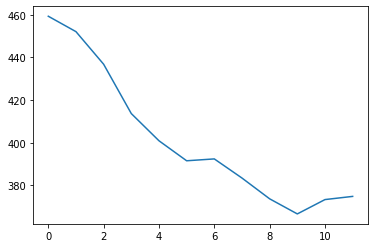

train ended


In [32]:
m4_gated = model_CIFAR10_gatedPool()
m4_gated.train(trainloader)

In [33]:
m4_gated.test(testloader)

c:\users\vera\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of plane: 45.455
Accuracy of car: 26.087
Accuracy of bird: 29.31
Accuracy of cat: 16.071
Accuracy of deer: 1.961
Accuracy of dog: 33.871
Accuracy of frog: 74.286
Accuracy of horse: 12.281
Accuracy of ship: 26.984
Accuracy of truck: 74.648
Mean accuracy = 36.5
